In [8]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
from source.models import U_Net
from source.dataloading import CroppedKiTSDataset
from source.transforms import HistogramEqualization, GaussianBlur, SuppressBackground
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [9]:
transform = transforms.Compose([
    GaussianBlur(kernel_size=5),
    HistogramEqualization(),
    transforms.ToTensor(),  
    SuppressBackground()
])
    
# Create dataset
base_path = r'C:\Users\pujau\OneDrive\Documents\thesis\kits19\data\test_data'
dataset = CroppedKiTSDataset(base_path, transform=transform, crop_size=(384, 384))
dataset_size = len(dataset)

# Check the length of the dataset
print(f'Length of dataset: {len(dataset)}')

# Create a DataLoader for the entire dataset
test_loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=False)

# Assuming you have defined test_loader
dataloaders = {
    'test': test_loader
}

print(f'Length of test_loader: {len(test_loader)}')

# Check a single batch
for batch in test_loader:
    image, mask = batch
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    break

Length of dataset: 5241
Length of test_loader: 5241
Image shape: torch.Size([1, 1, 384, 384]), Mask shape: torch.Size([1, 3, 384, 384])


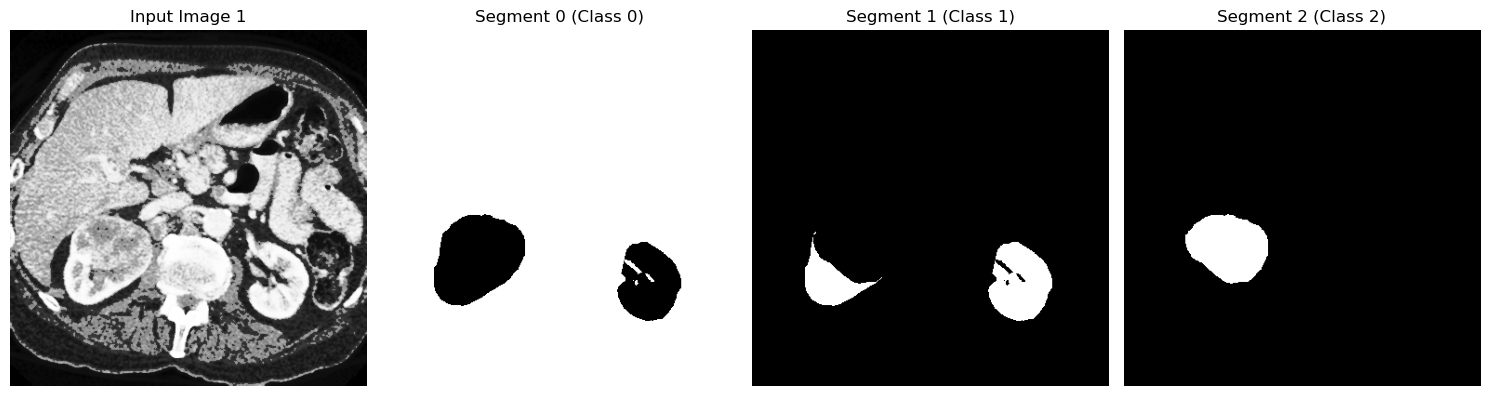

In [10]:
n = 35
for i, (images, labels) in enumerate(dataloaders['test']):
    if i == n:
        break  

# Now we have the entire batch (images and labels)
batch_size = images.size(0)  # Get the batch size
num_channels = labels.size(1)  # Number of segmentation channels (e.g., background, kidney, tumor)

# Create a subplot grid: one row per image, one column for the image and one for each segmentation class
fig, axes = plt.subplots(batch_size, num_channels + 1, figsize=(15, 5 * batch_size))

# If batch size is 1, we need to make sure axes are treated properly as 2D array
if batch_size == 1:
    axes = np.expand_dims(axes, axis=0)

for idx in range(batch_size):
    image = images[idx].squeeze().cpu().numpy()  # Get the image and squeeze to remove single dimensions
    label = labels[idx].cpu().numpy()  # Get the corresponding segmentation label

    # Plot the input image in the first column
    ax = axes[idx, 0]  # First column for input image
    ax.imshow(image, cmap='gray')  # Use 'gray' for grayscale medical images
    ax.set_title(f"Input Image {idx+1}")
    ax.axis('off')

    # Plot the segmentation masks in the remaining columns
    for c in range(num_channels):
        ax = axes[idx, c + 1]  # Remaining columns for segmentation classes
        ax.imshow(label[c, :, :], cmap='gray')  # Plot the segmentation mask for channel `c`
        ax.set_title(f'Segment {c} (Class {c})')
        ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Supporting metric functions
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    dice = (2. * intersection + smooth) / (np.sum(pred) + np.sum(target) + smooth)
    return dice

def jaccard_index(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard

def compute_precision(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    true_positives = np.sum(pred * target)
    false_positives = np.sum(pred * (1 - target))
    precision = (true_positives + smooth) / (true_positives + false_positives + smooth)
    return precision

def compute_sensitivity(pred, target, smooth=1e-6): #recall
    pred = pred.flatten()
    target = target.flatten()
    true_positives = np.sum(pred * target)
    false_negatives = np.sum(target * (1 - pred))
    sensitivity = (true_positives + smooth) / (true_positives + false_negatives + smooth)
    return sensitivity

In [12]:
def test_model(model, dataloaders, device):
    model.eval()
    num_classes = 3
    num_batches = 0

    # Initialize metric accumulators for kidney and tumor only
    total_dice_per_class = np.zeros(2)  # Only kidney and tumor
    total_jaccard_per_class = np.zeros(2)
    total_sensitivity_per_class = np.zeros(2)
    total_precision_per_class = np.zeros(2)
    slice_count_per_class = np.zeros(2)

    all_preds = []  # Collect predictions for visualization
    dataloader = tqdm(dataloaders['test'], desc='Testing', unit='batch')

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            preds = (preds > 0.5).float()
            all_preds.append(preds.cpu())

            # Compute metrics for kidney and tumor classes only
            for class_idx, (class_label, class_metrics_idx) in enumerate(zip(["Kidney", "Tumor"], [1, 2])):
                # Extract specific class channels for predictions and labels
                pred_class = preds[:, class_metrics_idx, :, :].cpu().numpy()
                label_class = labels[:, class_metrics_idx, :, :].cpu().numpy()

                # Mask to include only slices where the class is present
                presence_mask = label_class.sum(axis=(1, 2)) > 0
                pred_class_present = pred_class[presence_mask]
                label_class_present = label_class[presence_mask]

                # Count relevant slices for each class
                slice_count_per_class[class_idx] += presence_mask.sum()

                # Only compute metrics if the class is present in this batch
                if presence_mask.any():
                    dice = dice_coefficient(pred_class_present, label_class_present)
                    total_dice_per_class[class_idx] += dice

                    # Jaccard Index (IoU)
                    jaccard = jaccard_index(pred_class_present, label_class_present)
                    total_jaccard_per_class[class_idx] += jaccard

                    # Sensitivity (Recall)
                    sensitivity = compute_sensitivity(pred_class_present, label_class_present)
                    total_sensitivity_per_class[class_idx] += sensitivity

                    # Precision
                    precision = compute_precision(pred_class_present, label_class_present)
                    total_precision_per_class[class_idx] += precision

            num_batches += 1

    # Compute overall metrics per class using slice counts
    overall_mean_dice_per_class = (total_dice_per_class / slice_count_per_class) * 100
    overall_mean_jaccard_per_class = (total_jaccard_per_class / slice_count_per_class) * 100
    overall_mean_sensitivity_per_class = (total_sensitivity_per_class / slice_count_per_class) * 100
    overall_mean_precision_per_class = (total_precision_per_class / slice_count_per_class) * 100

    # Compute composite score (average of kidney and tumor)
    composite_dice = np.mean(overall_mean_dice_per_class)
    composite_jaccard = np.mean(overall_mean_jaccard_per_class)
    composite_sensitivity = np.mean(overall_mean_sensitivity_per_class)
    composite_precision = np.mean(overall_mean_precision_per_class)

    # Print metrics for each class (Kidney and Tumor)
    for idx, class_name in enumerate(["Kidney", "Tumor"]):
        print(f'{class_name} - Mean Dice: {overall_mean_dice_per_class[idx]:.4f}')
        print(f'{class_name} - Mean Jaccard: {overall_mean_jaccard_per_class[idx]:.4f}')
        print(f'{class_name} - Mean Sensitivity: {overall_mean_sensitivity_per_class[idx]:.4f}')
        print(f'{class_name} - Mean Precision: {overall_mean_precision_per_class[idx]:.4f}')
    
    # Print composite metrics across kidney and tumor classes
    print(f'Composite Dice (Kidney & Tumor): {composite_dice:.4f}')
    print(f'Composite Jaccard (Kidney & Tumor): {composite_jaccard:.4f}')
    print(f'Composite Sensitivity (Kidney & Tumor): {composite_sensitivity:.4f}')
    print(f'Composite Precision (Kidney & Tumor): {composite_precision:.4f}')

    return {
        'mean_dice': overall_mean_dice_per_class,
        'mean_jaccard': overall_mean_jaccard_per_class,
        'mean_sensitivity': overall_mean_sensitivity_per_class,
        'mean_precision': overall_mean_precision_per_class,
        'composite_dice': composite_dice,
        'composite_jaccard': composite_jaccard,
        'composite_sensitivity': composite_sensitivity,
        'composite_precision': composite_precision,
        'all_preds': torch.cat(all_preds),
    }


In [13]:
# Initialize and test the model
model = U_Net(img_ch=1, output_ch=3).to(device)
model.load_state_dict(torch.load('epoch_18_val_loss_0.0173.pth'))

metrics = test_model(model, dataloaders, device=device)

C:\Users\pujau\AppData\Local\Temp\ipykernel_11336\3545945295.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('epoch_18_val_loss_0.0173.p

Kidney - Mean Dice: 91.0318
Kidney - Mean Jaccard: 85.7883
Kidney - Mean Sensitivity: 90.3453
Kidney - Mean Precision: 94.9790
Tumor - Mean Dice: 62.8176
Tumor - Mean Jaccard: 53.1504
Tumor - Mean Sensitivity: 66.7713
Tumor - Mean Precision: 80.7901
Composite Dice (Kidney & Tumor): 76.9247
Composite Jaccard (Kidney & Tumor): 69.4693
Composite Sensitivity (Kidney & Tumor): 78.5583
Composite Precision (Kidney & Tumor): 87.8845


Shape of: image torch.Size([1, 384, 384]), segmentation torch.Size([3, 384, 384])
Shape of pred: (3, 384, 384)


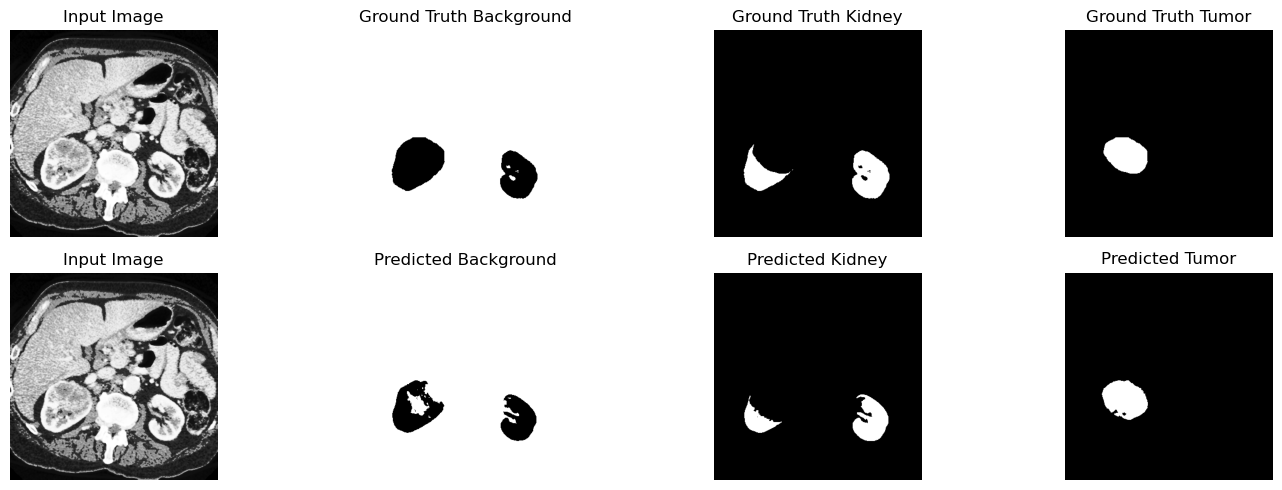

In [15]:
class_names = ["Background", "Kidney", "Tumor"]

n = 36
image, seg = dataset[n]
print(f"Shape of: image {image.shape}, segmentation {seg.shape}")
input = image.squeeze().cpu().numpy()  

# all_preds is batched, so to access the n-th prediction, we need to find its position
batch_size = dataloaders['test'].batch_size
pred = metrics['all_preds'][n // batch_size * batch_size + (n % batch_size)]  
pred = pred.cpu().numpy()  

print(f"Shape of pred: {pred.shape}")

# Visualize each channel separately
num_channels = seg.shape[0]
fig, axes = plt.subplots(2, num_channels + 1, figsize=(15, 5))

# Visualize the input image in the first row
ax = axes[0, 0]
ax.imshow(input, cmap='gray')
ax.set_title("Input Image")
ax.axis('off')

# Visualize the ground truth segmentation channels in the first row
for c in range(num_channels):
    ax = axes[0, c + 1]
    ax.imshow(seg[c, :, :], cmap='gray')
    ax.set_title(f'Ground Truth {class_names[c]}')
    ax.axis('off')

# Visualize the input image in the second row (optional, can be removed)
ax = axes[1, 0]
ax.imshow(input, cmap='gray')
ax.set_title("Input Image")
ax.axis('off')

# Visualize the predicted segmentation channels in the second row
for c in range(num_channels):
    ax = axes[1, c + 1]
    ax.imshow(pred[c, :, :], cmap='gray')
    ax.set_title(f'Predicted {class_names[c]}')
    ax.axis('off')

plt.tight_layout()
plt.show()